In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.special import entr
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import json
print(np.version.version)

1.19.5


In [2]:
pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='whitegrid', palette='deep', font_scale=1.2)
# this is for setting the precision to 4, so the data is better distributed on screen
# and the maximum number of columns to display
pd.set_option('max_columns',40, 'precision',4)

# Dataset Description
Four bearings were installed on a shaft. The rotation speed was kept constant at 2000 RPM by an AC motor coupled to the shaft via rub belts. A radial load of 6000 lbs is applied onto the shaft and bearing by a spring mechanism. All bearings are force lubricated.
Rexnord ZA-2115 double row bearings were installed on the shaft as shown in Figure 1. PCB 353B33 High Sensitivity Quartz ICP accelerometers were installed on the bearing housing (two accelerometers for each bearing [x- and y-axes] for data set 1, one accelerometer for each bearing for data sets 2 and 3). Sensor placement is also shown in Figure 1. All failures occurred after exceeding designed life time of the bearing which is more than 100 million revolutions.

## Data Structure

Three (3) data sets are included in the data packet (IMS-Rexnord Bearing Data.zip). Each data set describes a test-to-failure experiment. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at specific intervals. Each file consists of 20,480 points with the sampling rate set at 20 kHz. The file name indicates when the data was collected. Each record (row) in the data file is a data point. Data collection was facilitated by NI DAQ Card 6062E. Larger intervals of time stamps (showed in file names) indicate resumption of the experiment in the next working day.

## Set No. 1

| Index                    | Description                                                                                                                   |
|--------------------------|-------------------------------------------------------------------------------------------------------------------------------|
| Recording Duration:      | October 22, 2003 12:06:24 to November 25, 2003 23:39:56                                                                       |
| No. of Files:            | 2,156                                                                                                                         |
| No. of Channels:         | 8                                                                                                                             |
| Channel Arrangement:     | Bearing 1 – Ch 1&2; Bearing 2 – Ch 3&4; Bearing 3 – Ch 5&6; Bearing 4 – Ch 7&8.                                               |
| File Recording Interval: | Every 10 minutes (except the first 43 files were taken every 5 minutes)                                                       |
| File Format:             | ASCII                                                                                                                         |
| Description:             | At the end of the test-to-failure experiment, inner race defect occurred in bearing 3 and roller element defect in bearing 4. |

## Set No. 2

| Index                    | Description                                                                             |
|--------------------------|-----------------------------------------------------------------------------------------|
| Recording Duration:      | February 12, 2004 10:32:39 to February 19, 2004 06:22:39                                |
| No. of Files:            | 984                                                                                     |
| No. of Channels:         | 4                                                                                       |
| Channel Arrangement:     | Bearing 1 – Ch 1; Bearing2 – Ch 2; Bearing3 – Ch3; Bearing 4 – Ch 4.                    |
| File Recording Interval: | Every 10 minutes                                                                        |
| File Format:             | ASCII                                                                                   |
| Description:             | At the end of the test-to-failure experiment, outer race failure occurred in bearing 1. |

## Set No. 3

| Index                    | Description                                                                             |
|--------------------------|-----------------------------------------------------------------------------------------|
| Recording Duration:      | March 4, 2004 09:27:46 to April 4, 2004 19:01:57                                        |
| No. of Files:            | 4,448                                                                                   |
| No. of Channels:         | 4                                                                                       |
| Channel Arrangement:     | Bearing 1 – Ch 1; Bearing2 – Ch 2; Bearing3 – Ch3; Bearing 4 – Ch 4.                    |
| File Recording Interval: | Every 10 minutes                                                                        |
| File Format:             | ASCII                                                                                   |
| Description:             | At the end of the test-to-failure experiment, outer race failure occurred in bearing 3. |

In [3]:
dataset_path_1st = 'bearing-dataset/1st_test/1st_test/'
# Test for the first file
dataset = pd.read_csv((dataset_path_1st+'2003.10.22.12.06.24'), sep='\t')
dataset.columns = ['Bearing_1_ch1', 'Bearing_1_ch2','Bearing_2_ch3','Bearing_2_ch4','Bearing_3_ch5','Bearing_3_ch6', 'Bearing_4_ch7','Bearing_4_ch8']
dataset.head()

,Bearing_1_ch1,Bearing_1_ch2,Bearing_2_ch3,Bearing_2_ch4,Bearing_3_ch5,Bearing_3_ch6,Bearing_4_ch7,Bearing_4_ch8
0,-0.105,-0.017,-0.164,-0.183,-0.049,0.029,-0.115,-0.122
1,-0.183,-0.098,-0.195,-0.125,-0.005,-0.007,-0.171,-0.071
2,-0.178,-0.161,-0.159,-0.178,-0.100,-0.115,-0.112,-0.078
3,-0.208,-0.129,-0.261,-0.098,-0.151,-0.205,-0.063,-0.066
4,-0.232,-0.061,-0.281,-0.125,0.046,-0.088,-0.078,-0.078


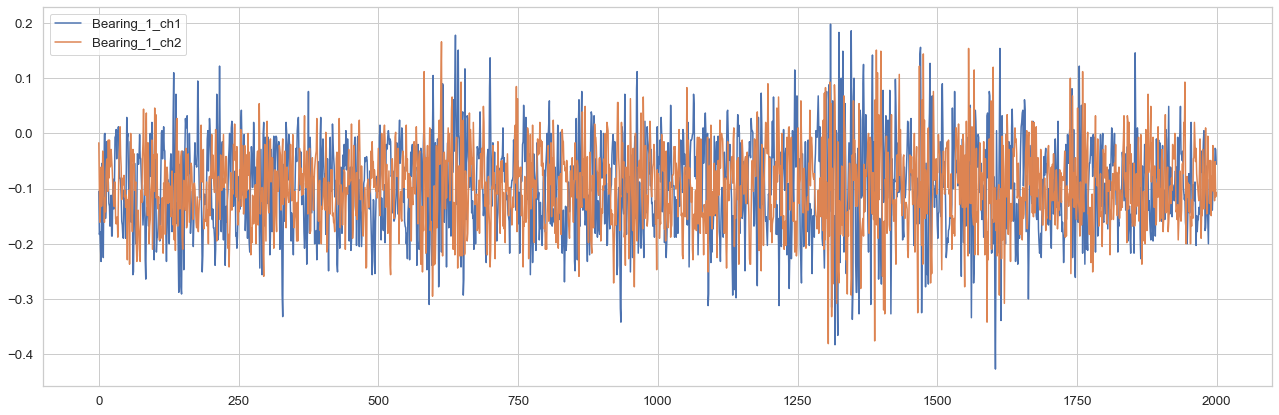

In [4]:
fig, ax1 = plt.subplots(1,1, figsize=(16, 5))
dataset[['Bearing_1_ch1']][:2000].plot(figsize=(18,6), ax=ax1)
dataset[['Bearing_1_ch2']][:2000].plot(figsize=(18,6), ax=ax1)
plt.tight_layout()

In [13]:
dataset_json = dataset[['Bearing_1_ch1']][:2000].reset_index().to_json(orient="records")
parsed = json.loads(dataset_json)

In [15]:
with open('bearingVibration.json', 'w') as outfile:
    json.dump(parsed, outfile)


In [37]:
# function to merge all files from bearing dataset
# taking the absolute mean from each day and creating a 
# daily time serie (5 days between entry)

def merge_data(dataset_path, id_set=None):
    data = pd.DataFrame()
    for filename in os.listdir(dataset_path):
        dataset=pd.read_csv(os.path.join(dataset_path, filename), sep='\t')
        dataset_mean_abs = np.array(dataset.abs().mean())
        if id_set == 1:
            dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,8))
        else:
            dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
        dataset_mean_abs.index = [filename]
        data = data.append(dataset_mean_abs)
    
    if id_set == 1:
        data.columns = ['B1_a','B1_b','B2_a','B2_b','B3_a','B3_b','B4_a','B4_b']
    else:
        data.columns = ['B1','B2','B3','B4']
        
    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    return data

In [39]:
set_1_df = merge_data(dataset_path_1st, 1)
set_1_df.head()

,B1_a,B1_b,B2_a,B2_b,B3_a,B3_b,B4_a,B4_b
2003-10-22 12:06:24,0.1041,0.1003,0.1071,0.1020,0.1061,0.1082,0.0948,0.0995
2003-10-22 12:09:13,0.1037,0.0999,0.1082,0.1029,0.1067,0.1085,0.0951,0.0936
2003-10-22 12:14:13,0.1050,0.1015,0.1085,0.1040,0.1087,0.1099,0.0962,0.0983
2003-10-22 12:19:13,0.1049,0.1016,0.1082,0.1034,0.1081,0.1100,0.0968,0.0986
2003-10-22 12:24:13,0.1048,0.1022,0.1079,0.1026,0.1085,0.1093,0.0964,0.0985


Wall time: 9min 10s
